# LiH: Confronto FCI e VQE con PUCCD

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.75, 4.2, 0.15) # (0.75, 4.2, 0.15) 4m 17s senza riduzione problema
arr_ground_energy = {}


## 1 - Algoritmo classico

### 1.1 - FCI

FCI per comparazione

In [27]:
from pyscf import gto, scf, fci

basis = 'sto-6g'

arr_ground_energy['FCI'] = []

for distance in arr_distance:
    geometry = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=geometry,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=True,
        verbose=0
    )
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    n_frozen_orbitals = 1 # per congelare il primo orbitale
    
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]
    arr_ground_energy['FCI'].append(e_FCI)

## 2 - VQE: pUCCD

Spezzetto il problema:
1. dichiarazione del problema
1. costruzione dell'ansatz
1. risoluzione

In [28]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

# dichiarazione del problema
def generate_LiH_problem (distance: float = .0, basis: str = 'sto-6g', reduce: bool = False):
    
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)

    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )    
    
    problem = driver.run()
    
    
    if reduce:
        # riduco il problema, estraendo uno stato iniziale HF dal problema ridotto da usare come initial_state
        # 1s (2e-) di Li in freeze. Restano 2 e- in 1σ e il 1σ* appena sopra, provo a costruirla così:
        transformer = ActiveSpaceTransformer(num_electrons=(1,1), num_spatial_orbitals=2, active_orbitals=[1,2]) 
        problem = transformer.transform(problem)
        
    return problem

In [29]:
from qiskit_nature.second_q.circuit.library import HartreeFock, PUCCD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

mapper = JordanWignerMapper()
#mapper = ParityMapper()

# costruzione dell'ansatz
def generate_ansatz ( problem, mapper = mapper ):
    
    ansatz = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    return ansatz

In [30]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.optimizers import NFT
from qiskit.primitives import Estimator 
# Estimator was deprecated, warnings suggest to use StatevectorEstimator instead

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
    
# risoluzione
def solve_problem (problem, ansatz, ini: np.ndarray = None, opt=SLSQP(maxiter=1000), mapper = mapper):

    vqe_solver = VQE( Estimator(), ansatz, opt ) #, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    return res

Metto tutto insieme

In [31]:
from qiskit_algorithms import NumPyMinimumEigensolver

# scelgo se congelare orbitali o meno
reduce = True # senza ci mette un po' tantino > 2min
# inizializzo variabile che conterrà i parametri ottimizzati
initial_point = None

# provo diversi ottimizzatori
arr_opt = [SLSQP(maxiter=1000), NFT(maxiter=1000), COBYLA(maxiter=1000)]
opt_names = ['pUCCD - SLSQP', 'pUCCD - NFT', 'pUCCD - COBYLA']

for opt, name in zip(arr_opt, opt_names):
    arr_ground_energy[name] = []
    
    # Esecuzione algoritmo
    for distance in arr_distance:
        
        # Problema da Driver della molecola 
        problem = generate_LiH_problem (distance, reduce=reduce)
        # Ansatz da problema con mapper default (JW)
        ansatz = generate_ansatz (problem)
        
        # Soluzione con VQE
        result = solve_problem (problem, ansatz, opt=opt,ini=initial_point)
        
        # Estraggo l'energia del sistema
        if reduce:
            computed_part = result.groundenergy
            active_space_energy_part = result.extracted_transformer_energies.get("ActiveSpaceTransformer", 0)
            nuclear_repulsion_energy = result.nuclear_repulsion_energy
            total_ground_energy = computed_part + active_space_energy_part + nuclear_repulsion_energy
        else:
            total_ground_energy = result.groundenergy
        
        arr_ground_energy[name].append(total_ground_energy)
        
        # salvo i parametri ottimizzati, da usare come pt iniziale del passo successivo
        initial_point = result.raw_result.optimal_point
        
        # optimal_parameters è il dict dei valori, point contiene solo i valori

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_84807/3155322571.py:13: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt ) #, callback=store_intermediate_result)
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_84807/3155322571.py:13: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansat

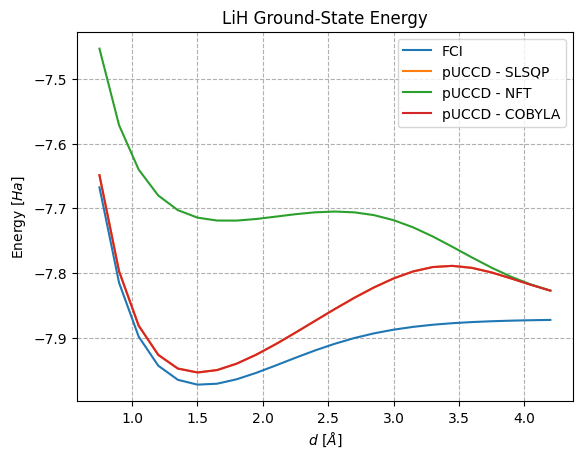

In [32]:
# Plot
method = ['FCI']
method.extend(opt_names)

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()
plt.show()

NFT sembra comportarsi diversamente rispetto agli altri optimizers. Riprovo senza condizione **maxiter**:

In [34]:
opt = NFT()

# Esecuzione algoritmo
for i in range(0,len(arr_distance)):
    
    # Problema da Driver della molecola 
    problem = generate_LiH_problem (distance, reduce=reduce)
    # Ansatz da problema con mapper default (JW)
    ansatz = generate_ansatz (problem)
    
    # Soluzione con VQE
    result = solve_problem (problem, ansatz, opt=opt,ini=initial_point)
    
    # Estraggo l'energia del sistema
    if reduce:
        computed_part = result.groundenergy
        active_space_energy_part = result.extracted_transformer_energies.get("ActiveSpaceTransformer", 0)
        nuclear_repulsion_energy = result.nuclear_repulsion_energy
        total_ground_energy = computed_part + active_space_energy_part + nuclear_repulsion_energy
    else:
        total_ground_energy = result.groundenergy
    
    arr_ground_energy['pUCCD - NFT'][i] = total_ground_energy
    
    # salvo i parametri ottimizzati, da usare come pt iniziale del passo successivo
    initial_point = result.raw_result.optimal_point

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_84807/3155322571.py:13: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt ) #, callback=store_intermediate_result)


{'FCI': [np.float64(-7.667474116900205), np.float64(-7.8148840686913355), np.float64(-7.898166491012294), np.float64(-7.943195280450719), np.float64(-7.9650019432973505), np.float64(-7.972464778981656), np.float64(-7.971025483998891), np.float64(-7.964165614717328), np.float64(-7.954203678721487), np.float64(-7.942741134497123), np.float64(-7.930921614517443), np.float64(-7.919578458033575), np.float64(-7.909304757501888), np.float64(-7.9004708879765815), np.float64(-7.893224757788603), np.float64(-7.8875153395182185), np.float64(-7.8831549765797755), np.float64(-7.879897370245679), np.float64(-7.877498541171521), np.float64(-7.875748352695574), np.float64(-7.874479191558681), np.float64(-7.8735629111953385), np.float64(-7.872903780404637), np.float64(-7.872431184215426)], 'pUCCD - SLSQP': [np.float64(-7.648704863193238), np.float64(-7.7972319893879325), np.float64(-7.881302933121255), np.float64(-7.926463564127226), np.float64(-7.9476257673547845), np.float64(-7.9536447446372085), np.

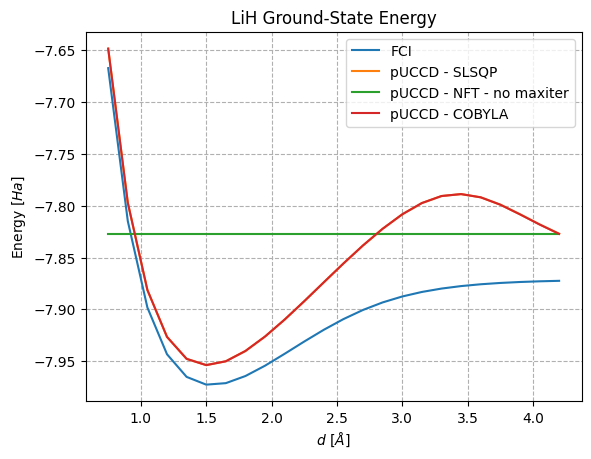

In [39]:
# Rifaccio il plot
arr_ground_energy['pUCCD - NFT - no maxiter'] = arr_ground_energy.pop('pUCCD - NFT')
opt_names = ['pUCCD - SLSQP', 'pUCCD - NFT - no maxiter', 'pUCCD - COBYLA']

# Plot
method = ['FCI']
method.extend(opt_names)

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()
plt.show()

La situazione non migliora.